In [1]:
#!pip list
%pip install pandas scikit-learn matplotlib seaborn librosa 
%pip install xgboost --no-deps
%pip install lightgbm 

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import librosa
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import ast

import re

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# 1. Load raw data

In [3]:
df = pd.read_csv('train_set.csv')


In [4]:
df.head()

,file,sampling_rate,channel_1,channel_2,ratios,label
0,8ab4ffda-6f7d-4fd8-9fc4-5d00e7798d43_22281325_...,8000,{'segments': {'segment_1': {'f0_mean': 329.527...,{'segments': {'segment_1': {'f0_mean': 465.244...,"{'overall': {'f0_mean': 0.6529480783025756, 'f...",1
1,fec28b84-69e8-4d83-bea1-70d825050057_22237809_...,8000,{'segments': {'segment_1': {'f0_mean': 369.308...,{'segments': {'segment_1': {'f0_mean': 434.658...,"{'overall': {'f0_mean': 0.6186414294558663, 'f...",0
2,007554e2-9c6f-495b-8a9e-b0afbd948bf3_22197563_...,8000,{'segments': {'segment_1': {'f0_mean': 298.181...,{'segments': {'segment_1': {'f0_mean': 402.850...,"{'overall': {'f0_mean': 0.7379481569593161, 'f...",0
3,2d4b31ef-a683-4d9e-bc54-3d7bd5a758d8_22237750_...,8000,{'segments': {'segment_1': {'f0_mean': 356.413...,{'segments': {'segment_1': {'f0_mean': 395.966...,"{'overall': {'f0_mean': 0.9128097966131058, 'f...",0
4,b9a6592a-376e-4094-8ab5-e7dd25fac4c1_22214911_...,8000,{'segments': {'segment_1': {'f0_mean': 355.541...,{'segments': {'segment_1': {'f0_mean': 371.768...,"{'overall': {'f0_mean': 0.9219474432548425, 'f...",0


In [5]:
df.shape

(895, 6)

In [6]:
df.loc[0, 'channel_2']

"{'segments': {'segment_1': {'f0_mean': 465.24463392898286, 'f0_std': 60.064785380226176, 'f0_min': 229.0776735576574, 'f0_max': 499.62194879118596, 'f0_range': 270.54427523352854, 'f0_slope': 0.22975569559829906, 'f0_rising_pct': 18.064516129032256, 'rms_mean': 0.008985956199467182, 'rms_std': 0.021045710891485214, 'rms_min': 1.000000884232577e-05, 'rms_max': 0.10195433348417282, 'rms_range': 0.1019443334753305, 'db_mean': -58.71998977661133, 'db_std': 28.305564880371094, 'db_min': -80.16810607910156, 'db_max': 0.0, 'db_range': 80.16810607910156, 'formant1': 484.33051705298203, 'formant2': 952.1380364285455, 'voiced_ratio': 0.6946914578280787, 'speech_rate': 21.71374786405324, 'laughter': False}, 'segment_2': {'f0_mean': 460.89052427488576, 'f0_std': 23.527476891082543, 'f0_min': 403.4817790100553, 'f0_max': 499.62194879118596, 'f0_range': 96.14016978113068, 'f0_slope': -0.008486248913548069, 'f0_rising_pct': 22.28187919463087, 'rms_mean': 0.021944213658571243, 'rms_std': 0.0282049831

In [7]:
# some data has nan 
df.loc[821, 'ratios']

"{'overall': {'f0_mean': 1.3454828448916696, 'f0_std': 0.19949521814518636, 'f0_min': 1.9207458901020082, 'f0_max': 1.0, 'f0_range': 0.39994639595560605, 'f0_slope': nan, 'f0_rising_pct': 0.943153953521236, 'rms_mean': 2.5477451818746437, 'rms_std': 2.592209233903075, 'rms_min': 1.0, 'rms_max': 2.816940203525856, 'rms_range': 2.8171172675976126, 'db_mean': 0.9927130223837168, 'db_std': 0.8143357957396867, 'db_min': 1.1121287751570146, 'db_max': None, 'db_range': 1.1121287751570146, 'formant1': 0.9605229844303151, 'formant2': 0.7836192473638436, 'voiced_ratio': 0.9180653311676592, 'speech_rate': 0.9180653311676593, 'laughter': 0}, 'segments': {}}"

# 2. data cleaning 1: change the string of dict to dict

In [8]:
def safe_literal_eval(val):
    if isinstance(val, str):
        # Replace nan with None (case-insensitive)
        val = re.sub(r'\bnan\b', 'None', val, flags=re.IGNORECASE)
        try:
            return ast.literal_eval(val)
        except Exception as e:
            print(f"Could not parse: {val[:100]}... Exception: {e}")
            return val
    return val

for col in ['channel_1', 'channel_2', 'ratios']:
    df[col] = df[col].apply(safe_literal_eval)

In [9]:
len(df.loc[279, 'channel_2']['segments']['segment_2'].keys())

22

# 3.  train test split: imbalanced classes

In [10]:
from sklearn.model_selection import train_test_split

# Use stratify to maintain class balance in both splits
train_df, test_df = train_test_split(
    df, 
    test_size=0.2, 
    random_state=42, 
    stratify=df['label']  # This ensures 10%/90% in both train and test
)

print("Train set class distribution:")
print(train_df['label'].value_counts(normalize=True))
print("\nTest set class distribution:")
print(test_df['label'].value_counts(normalize=True))

Train set class distribution:
label
0    0.903631
1    0.096369
Name: proportion, dtype: float64

Test set class distribution:
label
0    0.905028
1    0.094972
Name: proportion, dtype: float64


# 4.  data structure
1. for every sample, it has three main features: channel_1 (customer), channel_2 (sales agent), ratios; and label.
2. for channel_1(2), each sample has two kv pair: 'segments' (has 3 sub segments) and 'overall'. 
3. for ratios, each sample has two kv pair: 'segmments' (empty) and 'overall'.

# 5. Train with overall features

## 5.1 Extract overall features

In [11]:
def extract_overall_features(row):
    features = {}
    for col in ['channel_1', 'channel_2', 'ratios']:
        if isinstance(row[col], dict) and 'overall' in row[col]:
            overall = row[col]['overall']
            for k, v in overall.items():
                features[f"{col}_overall_{k}"] = v
        else:
            # Handle cases where conversion failed
            for i in range(22):  # assuming 22 features per channel
                features[f"{col}_overall_feature_{i}"] = None
    return pd.Series(features)

In [12]:
# Extract features for train and test sets
train_features = train_df.apply(extract_overall_features, axis=1)
test_features = test_df.apply(extract_overall_features, axis=1)


# 6. Data issues
One column 'channel_2_overall_db_max' contains only 0.  
some columns are true/false, 
some columns has missing values. 
Different columns have very much different range. 

## 6.1 data quality analysis. This can be done with data wrangler as well.

In [13]:
print("=== Data Quality Analysis ===")
print(f"Shape: {train_features.shape}")
print(f"Missing values per column:")
print(train_features.isnull().sum().sort_values(ascending=False).head(10))

print(f"\nColumns with only one unique value:")
constant_cols = [col for col in train_features.columns if train_features[col].nunique() <= 1]
print(constant_cols)

print(f"\nData types:")
print(train_features.dtypes.value_counts())

print(f"\nBoolean columns:")
bool_cols = [col for col in train_features.columns if train_features[col].dtype == 'bool' or set(train_features[col].dropna().unique()).issubset({0, 1, True, False})]
print(bool_cols[:10])  # Show first 10

=== Data Quality Analysis ===
Shape: (716, 66)
Missing values per column:
ratios_overall_db_max           716
ratios_overall_f0_min           119
ratios_overall_f0_slope          15
ratios_overall_f0_std             7
ratios_overall_f0_rising_pct      7
channel_1_overall_f0_slope        5
ratios_overall_f0_mean            5
ratios_overall_f0_range           5
ratios_overall_f0_max             5
channel_2_overall_f0_slope        4
dtype: int64

Columns with only one unique value:
['channel_1_overall_db_max', 'channel_2_overall_db_max', 'ratios_overall_db_max']

Data types:
float64    62
bool        2
object      1
int64       1
Name: count, dtype: int64

Boolean columns:
['channel_1_overall_db_max', 'channel_1_overall_laughter', 'channel_2_overall_db_max', 'channel_2_overall_laughter', 'ratios_overall_db_max']


# 7 data cleaning 2: fix the above issues

In [14]:
def preprocess_features(train_features, test_features):
    print("=== Preprocessing Features ===")
    
    # 1. Remove constant columns AND columns with too many missing values
    constant_cols = [col for col in train_features.columns if train_features[col].nunique() <= 1]
    
    # Remove columns with >95% missing values (ratios_overall_db_max with 100% missing)
    high_missing_cols = [col for col in train_features.columns if train_features[col].isnull().sum() / len(train_features) > 0.95]
    
    cols_to_remove = list(set(constant_cols + high_missing_cols))
    print(f"Removing {len(constant_cols)} constant columns: {constant_cols}")
    print(f"Removing {len(high_missing_cols)} high-missing columns: {high_missing_cols}")
    print(f"Total columns to remove: {cols_to_remove}")
    
    train_clean = train_features.drop(columns=cols_to_remove)
    test_clean = test_features.drop(columns=cols_to_remove)
    
    # 2. Handle remaining missing values
    print(f"Shape before imputation: {train_clean.shape}")
    print(f"Missing values before imputation: {train_clean.isnull().sum().sum()}")
    
    imputer = SimpleImputer(strategy='median')
    train_imputed = pd.DataFrame(
        imputer.fit_transform(train_clean), 
        columns=train_clean.columns,
        index=train_clean.index
    )
    test_imputed = pd.DataFrame(
        imputer.transform(test_clean), 
        columns=test_clean.columns,
        index=test_clean.index
    )
    
    print(f"Missing values after imputation: {train_imputed.isnull().sum().sum()}")
    
    # 3. Scale features (handle different ranges)
    scaler = StandardScaler()
    train_scaled = pd.DataFrame(
        scaler.fit_transform(train_imputed),
        columns=train_imputed.columns,
        index=train_imputed.index
    )
    test_scaled = pd.DataFrame(
        scaler.transform(test_imputed),
        columns=test_imputed.columns,
        index=test_imputed.index
    )
    
    print(f"Final preprocessed shape: {train_scaled.shape}")
    return train_scaled, test_scaled, imputer, scaler

In [15]:
# Apply preprocessing
X_train, X_test, imputer, scaler = preprocess_features(train_features, test_features)
y_train = train_df['label'].reset_index(drop=True)
y_test = test_df['label'].reset_index(drop=True)

print(f"\nFinal dataset info:")
print(f"Training features: {X_train.shape}")
print(f"Test features: {X_test.shape}")

=== Preprocessing Features ===
Removing 3 constant columns: ['channel_1_overall_db_max', 'channel_2_overall_db_max', 'ratios_overall_db_max']
Removing 1 high-missing columns: ['ratios_overall_db_max']
Total columns to remove: ['ratios_overall_db_max', 'channel_2_overall_db_max', 'channel_1_overall_db_max']
Shape before imputation: (716, 63)
Missing values before imputation: 172
Missing values after imputation: 0
Final preprocessed shape: (716, 63)

Final dataset info:
Training features: (716, 63)
Test features: (179, 63)


### 7.1 check the imputed value

In [16]:
print("Imputer statistics (median values for each column):")
print(imputer.statistics_)

# 2. See which features it was trained on
print("Feature names:")
print(imputer.feature_names_in_)

# 3. Use it to transform new data with the same missing value strategy
# new_data_imputed = imputer.transform(new_data)

# 4. See the imputation strategy
print(f"Imputation strategy: {imputer.strategy}")

Imputer statistics (median values for each column):
[ 3.62563524e+02  5.56775161e+01  6.61663770e+01  4.99621949e+02
  4.23210458e+02 -1.20139452e-02  2.14061146e+01  1.69436840e-02
  2.77205355e-02  1.00000007e-05  1.27181739e-01  1.27171700e-01
 -4.05766341e+01  2.19555454e+01 -8.17652130e+01  8.17652130e+01
  2.32048220e+03  1.86684430e+03  4.11244109e-01  1.28524410e+01
  0.00000000e+00  3.32877501e+02  4.60613483e+01  9.22322293e+01
  4.99621949e+02  3.49602800e+02 -7.51839113e-03  2.19788448e+01
  1.11150185e-02  2.09324652e-02  1.00000088e-05  9.25171934e-02
  9.25069449e-02 -3.86353728e+01  1.95615721e+01 -7.86556778e+01
  7.86556778e+01  3.18520119e+03  2.37166372e+03  2.88508329e-01
  9.01751600e+00  0.00000000e+00  1.07018191e+00  1.24740544e+00
  9.88514020e-01  1.00000000e+00  1.00090902e+00  2.88239466e-02
  9.73273762e-01  1.53865467e+00  1.39693116e+00  9.99999363e-01
  1.42883628e+00  1.42887069e+00  1.05395257e+00  1.13324227e+00
  1.04298645e+00  1.04298645e+00  9.37

# 8. first model: basic RandomForestClassifier

In [17]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(
    class_weight='balanced',  # Automatically adjusts for imbalance
    random_state=42
)

In [18]:
# Train the model
print("=== Training Model ===")
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test) # using default threshold of 0.5 
y_pred_proba = clf.predict_proba(X_test)[:, 1]

print("Model training completed!")

=== Training Model ===
Model training completed!


## 8.1 Eval

In [19]:
from sklearn.metrics import classification_report, roc_auc_score

from sklearn.metrics import classification_report, roc_auc_score, precision_score

print("=== Model Performance ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.3f}")
print(f"Precision: {precision_score(y_test, y_pred):.3f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba):.3f}")

print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred))

# Check prediction distribution
print(f"\nPrediction distribution:")
print(f"Predicted 0 (unsuccessful): {sum(y_pred == 0)}")
print(f"Predicted 1 (successful): {sum(y_pred == 1)}")
print(f"Actual successful calls in test: {sum(y_test == 1)}")

=== Model Performance ===
Accuracy: 0.950
F1 Score: 0.727
Precision: 0.750
ROC AUC: 0.984

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       162
           1       0.75      0.71      0.73        17

    accuracy                           0.95       179
   macro avg       0.86      0.84      0.85       179
weighted avg       0.95      0.95      0.95       179


Prediction distribution:
Predicted 0 (unsuccessful): 163
Predicted 1 (successful): 16
Actual successful calls in test: 17


## 8.2 feature importance

=== Top 15 Most Important Features for Sales Success ===
 1. channel_2_overall_formant1               0.2420
 2. channel_1_overall_formant1               0.1815
 3. channel_2_overall_formant2               0.1366
 4. channel_1_overall_formant2               0.1283
 5. ratios_overall_formant1                  0.0454
 6. ratios_overall_formant2                  0.0351
 7. ratios_overall_rms_mean                  0.0138
 8. channel_2_overall_db_std                 0.0129
 9. channel_1_overall_db_mean                0.0114
10. channel_2_overall_f0_std                 0.0107
11. ratios_overall_db_mean                   0.0102
12. channel_2_overall_f0_range               0.0090
13. channel_2_overall_f0_slope               0.0077
14. channel_2_overall_f0_mean                0.0063
15. channel_1_overall_f0_std                 0.0060


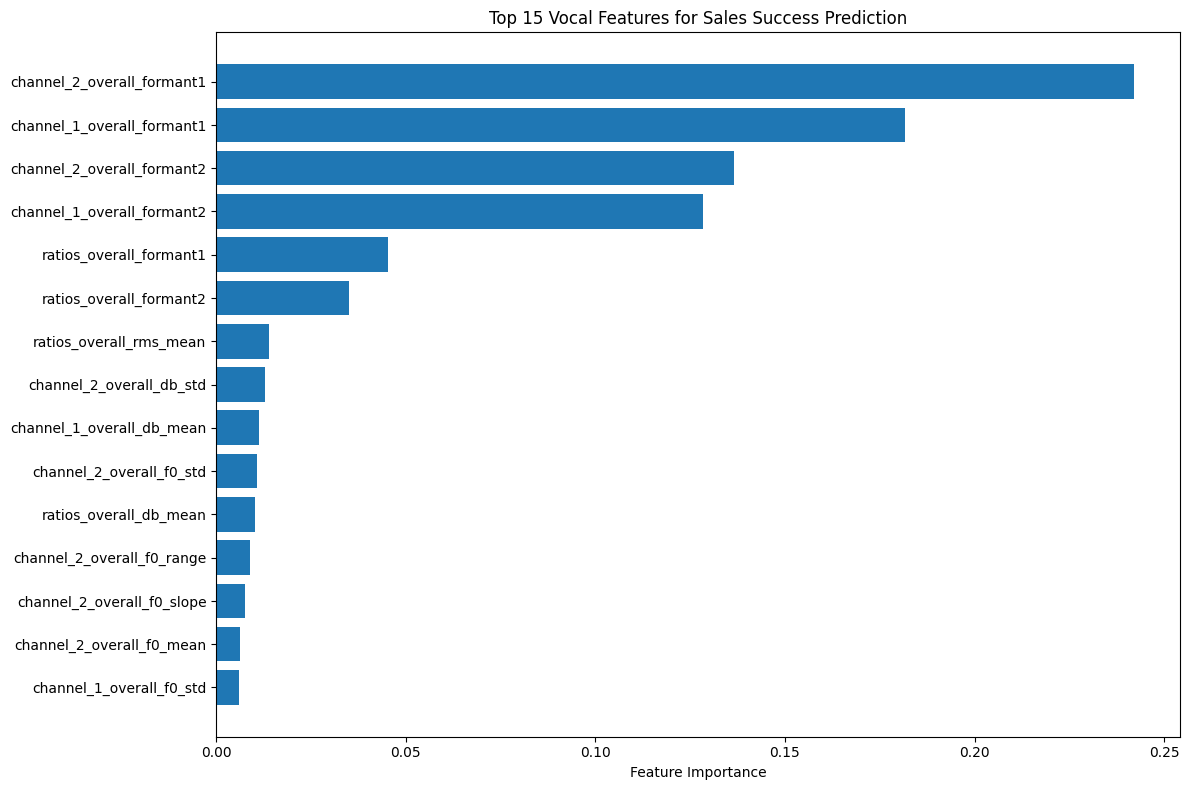

In [20]:
# Analyze which vocal features predict sales success
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': clf.feature_importances_
}).sort_values('importance', ascending=False)

print("=== Top 15 Most Important Features for Sales Success ===")
top_features = feature_importance.head(15)
for i, (_, row) in enumerate(top_features.iterrows(), 1):
    print(f"{i:2d}. {row['feature']:<40} {row['importance']:.4f}")

# Plot feature importance
plt.figure(figsize=(12, 8))
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 15 Vocal Features for Sales Success Prediction')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 8.3 Improvement on F1 (stable solution with both precision and recall in consideration)

In [21]:
# Optimize decision threshold for better F1

thresholds = np.arange(0.1, 0.9, 0.05)
f1_scores = []

for threshold in thresholds:
    y_pred_threshold = (y_pred_proba >= threshold).astype(int)
    #print(y_pred_threshold)
    f1 = f1_score(y_test, y_pred_threshold)
    f1_scores.append(f1)
    print(f"Threshold {threshold:.2f}: F1 = {f1:.3f}")

# Find optimal threshold
best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = max(f1_scores)
print(f"\nOptimal threshold: {best_threshold:.2f}")
print(f"Best F1 score: {best_f1:.3f}")

# Apply optimal threshold
y_pred_optimized = (y_pred_proba >= best_threshold).astype(int)
print(f"Optimized F1: {f1_score(y_test, y_pred_optimized):.3f}")

Threshold 0.10: F1 = 0.773
Threshold 0.15: F1 = 0.850
Threshold 0.20: F1 = 0.872
Threshold 0.25: F1 = 0.872
Threshold 0.30: F1 = 0.842
Threshold 0.35: F1 = 0.842
Threshold 0.40: F1 = 0.811
Threshold 0.45: F1 = 0.800
Threshold 0.50: F1 = 0.727
Threshold 0.55: F1 = 0.667
Threshold 0.60: F1 = 0.621
Threshold 0.65: F1 = 0.621
Threshold 0.70: F1 = 0.593
Threshold 0.75: F1 = 0.480
Threshold 0.80: F1 = 0.435
Threshold 0.85: F1 = 0.286

Optimal threshold: 0.20
Best F1 score: 0.872
Optimized F1: 0.872


In [22]:
from sklearn.metrics import precision_score, recall_score, classification_report

y_pred_optimized = (y_pred_proba >= 0.20).astype(int)

print("=== Optimized Model Performance (Threshold = 0.20) ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_optimized):.3f}")
print(f"F1 Score: {f1_score(y_test, y_pred_optimized):.3f}")
print(f"Precision: {precision_score(y_test, y_pred_optimized):.3f}")
print(f"Recall: {recall_score(y_test, y_pred_optimized):.3f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba):.3f}")  # Same as before

print("\nOptimized Classification Report:")
print(classification_report(y_test, y_pred_optimized))

print(f"\nOptimized Prediction Distribution:")
print(f"Predicted 0 (unsuccessful): {sum(y_pred_optimized == 0)}")
print(f"Predicted 1 (successful): {sum(y_pred_optimized == 1)}")
print(f"Actual successful calls: {sum(y_test == 1)}")

=== Optimized Model Performance (Threshold = 0.20) ===
Accuracy: 0.972
F1 Score: 0.872
Precision: 0.773
Recall: 1.000
ROC AUC: 0.984

Optimized Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98       162
           1       0.77      1.00      0.87        17

    accuracy                           0.97       179
   macro avg       0.89      0.98      0.93       179
weighted avg       0.98      0.97      0.97       179


Optimized Prediction Distribution:
Predicted 0 (unsuccessful): 157
Predicted 1 (successful): 22
Actual successful calls: 17


### model 1 conclusion:
1. 100% recall: the model catches ALL successful sales calls. 
2. 0.2 is an optimal thres. 
3. All the metrics are good
4. precision 77.3%: the model predicts some negative case as positive.
5. this is acceptable: better to have false pos than false neg (rather waste time on a few extra calls than miss a potential sale).

# 9. Second model: RandomForestClassifier with hyperparamter tuning

In [23]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import numpy as np

print("=== Advanced Model with Hyperparameter Tuning ===")

# Define parameter grid for tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

# Create base model
rf_base = RandomForestClassifier(
    class_weight='balanced',
    random_state=42,
    n_jobs=-1  # Use all CPU cores
)

# Randomized search (faster than GridSearch for large parameter space)
print("Starting hyperparameter search...")
random_search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_grid,
    n_iter=50,  # Try 50 random combinations
    cv=5,       # 5-fold cross-validation
    scoring='f1',  # Optimize for F1 score
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Fit the random search
random_search.fit(X_train, y_train)

print(f"\nBest parameters found:")
for param, value in random_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nBest cross-validation F1 score: {random_search.best_score_:.3f}")

# Get the best model
clf_advanced = random_search.best_estimator_

=== Advanced Model with Hyperparameter Tuning ===
Starting hyperparameter search...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Best parameters found:
  n_estimators: 100
  min_samples_split: 10
  min_samples_leaf: 4
  max_features: sqrt
  max_depth: 20
  bootstrap: False

Best cross-validation F1 score: 0.838


In [24]:
# Train and evaluate the advanced model
print("\n=== Training Advanced Model ===")
clf_advanced.fit(X_train, y_train)

# Make predictions
y_pred_advanced = clf_advanced.predict(X_test)
y_pred_proba_advanced = clf_advanced.predict_proba(X_test)[:, 1]

print("Advanced model training completed!")


=== Training Advanced Model ===
Advanced model training completed!


In [25]:
# Evaluate advanced model with default threshold
from sklearn.metrics import precision_score, recall_score, classification_report

print("=== Advanced Model Performance (Default Threshold = 0.5) ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_advanced):.3f}")
print(f"F1 Score: {f1_score(y_test, y_pred_advanced):.3f}")
print(f"Precision: {precision_score(y_test, y_pred_advanced):.3f}")
print(f"Recall: {recall_score(y_test, y_pred_advanced):.3f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba_advanced):.3f}")

=== Advanced Model Performance (Default Threshold = 0.5) ===
Accuracy: 0.972
F1 Score: 0.872
Precision: 0.773
Recall: 1.000
ROC AUC: 0.982


In [26]:
# Optimize threshold for advanced model
print("\n=== Optimizing Threshold for Advanced Model ===")
thresholds = np.arange(0.1, 0.9, 0.05)
f1_scores_advanced = []

for threshold in thresholds:
    y_pred_threshold_advanced = (y_pred_proba_advanced >= threshold).astype(int)
    f1 = f1_score(y_test, y_pred_threshold_advanced)
    f1_scores_advanced.append(f1)

# Find optimal threshold for advanced model
best_threshold_advanced = thresholds[np.argmax(f1_scores_advanced)]
best_f1_advanced = max(f1_scores_advanced)

print(f"Optimal threshold for advanced model: {best_threshold_advanced:.2f}")
print(f"Best F1 score: {best_f1_advanced:.3f}")

# Apply optimal threshold to advanced model
y_pred_optimized_advanced = (y_pred_proba_advanced >= best_threshold_advanced).astype(int)


=== Optimizing Threshold for Advanced Model ===
Optimal threshold for advanced model: 0.50
Best F1 score: 0.872


In [27]:
# Compare 2nd model with optimized 1st model
print("\n" + "="*60)
print("MODEL COMPARISON")
print("="*60)

print(f"{'Metric':<15} | {'Original':<10} | {'Advanced':<10} | {'Improvement'}")
print("-" * 60)

# Original model metrics (with optimized threshold 0.20)
orig_acc = accuracy_score(y_test, y_pred_optimized)
orig_f1 = f1_score(y_test, y_pred_optimized)
orig_prec = precision_score(y_test, y_pred_optimized)
orig_rec = recall_score(y_test, y_pred_optimized)

# Advanced model metrics (with its optimized threshold)
adv_acc = accuracy_score(y_test, y_pred_optimized_advanced)
adv_f1 = f1_score(y_test, y_pred_optimized_advanced)
adv_prec = precision_score(y_test, y_pred_optimized_advanced)
adv_rec = recall_score(y_test, y_pred_optimized_advanced)

print(f"{'Accuracy':<15} | {orig_acc:<10.3f} | {adv_acc:<10.3f} | {'+' if adv_acc > orig_acc else ''}{(adv_acc - orig_acc)*100:+.1f}%")
print(f"{'F1 Score':<15} | {orig_f1:<10.3f} | {adv_f1:<10.3f} | {'+' if adv_f1 > orig_f1 else ''}{(adv_f1 - orig_f1)*100:+.1f}%")
print(f"{'Precision':<15} | {orig_prec:<10.3f} | {adv_prec:<10.3f} | {'+' if adv_prec > orig_prec else ''}{(adv_prec - orig_prec)*100:+.1f}%")
print(f"{'Recall':<15} | {orig_rec:<10.3f} | {adv_rec:<10.3f} | {'+' if adv_rec > orig_rec else ''}{(adv_rec - orig_rec)*100:+.1f}%")

print(f"\nOptimal thresholds:")
print(f"Original model: 0.20")
print(f"Advanced model: {best_threshold_advanced:.2f}")


MODEL COMPARISON
Metric          | Original   | Advanced   | Improvement
------------------------------------------------------------
Accuracy        | 0.972      | 0.972      | +0.0%
F1 Score        | 0.872      | 0.872      | +0.0%
Precision       | 0.773      | 0.773      | +0.0%
Recall          | 1.000      | 1.000      | +0.0%

Optimal thresholds:
Original model: 0.20
Advanced model: 0.50


# 10. Third model: top 15 features
to see if fewer features can make the precision better 

In [28]:
# Get top 15 features from original model
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': clf.feature_importances_
}).sort_values('importance', ascending=False)

top_15_features = feature_importance.head(15)['feature'].tolist()

print("=== Top 15 Features Selected ===")
for i, feature in enumerate(top_15_features, 1):
    importance = feature_importance[feature_importance['feature'] == feature]['importance'].iloc[0]
    print(f"{i:2d}. {feature:<40} {importance:.4f}")

=== Top 15 Features Selected ===
 1. channel_2_overall_formant1               0.2420
 2. channel_1_overall_formant1               0.1815
 3. channel_2_overall_formant2               0.1366
 4. channel_1_overall_formant2               0.1283
 5. ratios_overall_formant1                  0.0454
 6. ratios_overall_formant2                  0.0351
 7. ratios_overall_rms_mean                  0.0138
 8. channel_2_overall_db_std                 0.0129
 9. channel_1_overall_db_mean                0.0114
10. channel_2_overall_f0_std                 0.0107
11. ratios_overall_db_mean                   0.0102
12. channel_2_overall_f0_range               0.0090
13. channel_2_overall_f0_slope               0.0077
14. channel_2_overall_f0_mean                0.0063
15. channel_1_overall_f0_std                 0.0060


In [29]:
# Create training and test sets with only top 15 features
X_train_top15 = X_train[top_15_features]
X_test_top15 = X_test[top_15_features]

print(f"\nReduced dataset shape:")
print(f"Original features: {X_train.shape[1]}")
print(f"Top 15 features: {X_train_top15.shape[1]}")
print(f"Feature reduction: {((X_train.shape[1] - 15) / X_train.shape[1] * 100):.1f}%")


Reduced dataset shape:
Original features: 63
Top 15 features: 15
Feature reduction: 76.2%


In [30]:
# Train the top 15 features model
print("\n=== Training Top 15 Features Model ===")

clf_top15 = RandomForestClassifier(
    class_weight='balanced',
    random_state=42,
    n_estimators=100,  # Use same as original for fair comparison
)

clf_top15.fit(X_train_top15, y_train)

# Make predictions
y_pred_top15 = clf_top15.predict(X_test_top15)
y_pred_proba_top15 = clf_top15.predict_proba(X_test_top15)[:, 1]

print("Top 15 features model training completed!")


=== Training Top 15 Features Model ===
Top 15 features model training completed!


In [31]:
# Evaluate with default threshold first
print("\n=== Top 15 Features Model Performance with default threshold = 0.5 ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_top15):.3f}")
print(f"F1 Score: {f1_score(y_test, y_pred_top15):.3f}")
print(f"Precision: {precision_score(y_test, y_pred_top15):.3f}")
print(f"Recall: {recall_score(y_test, y_pred_top15):.3f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba_top15):.3f}")


=== Top 15 Features Model Performance with default threshold = 0.5 ===
Accuracy: 0.939
F1 Score: 0.667
Precision: 0.688
Recall: 0.647
ROC AUC: 0.977


In [32]:
# Optimize threshold for top 15 model
print("\n=== Optimizing Threshold for Top 15 Features Model ===")
thresholds = np.arange(0.1, 0.9, 0.05)
f1_scores_top15 = []

for threshold in thresholds:
    y_pred_threshold_top15 = (y_pred_proba_top15 >= threshold).astype(int)
    f1 = f1_score(y_test, y_pred_threshold_top15)
    f1_scores_top15.append(f1)

# Find optimal threshold for top 15 model
best_threshold_top15 = thresholds[np.argmax(f1_scores_top15)]
best_f1_top15 = max(f1_scores_top15)

print(f"Optimal threshold for top 15 model: {best_threshold_top15:.2f}")
print(f"Best F1 score: {best_f1_top15:.3f}")

# Apply optimal threshold to top 15 model
y_pred_optimized_top15 = (y_pred_proba_top15 >= best_threshold_top15).astype(int)


=== Optimizing Threshold for Top 15 Features Model ===
Optimal threshold for top 15 model: 0.25
Best F1 score: 0.850


In [33]:
# Compare all three models so far
print("\n" + "="*80)
print("THREE-MODEL COMPARISON")
print("="*80)

print(f"{'Metric':<15} | {'Original':<10} | {'Advanced':<10} | {'Top 15':<10} | {'Best Model'}")
print("-" * 80)

# Calculate metrics for top 15 model
top15_acc = accuracy_score(y_test, y_pred_optimized_top15)
top15_f1 = f1_score(y_test, y_pred_optimized_top15)
top15_prec = precision_score(y_test, y_pred_optimized_top15)
top15_rec = recall_score(y_test, y_pred_optimized_top15)

# Find best for each metric
best_acc = max(orig_acc, adv_acc, top15_acc)
best_f1 = max(orig_f1, adv_f1, top15_f1)
best_prec = max(orig_prec, adv_prec, top15_prec)
best_rec = max(orig_rec, adv_rec, top15_rec)

def get_winner(orig, adv, top15):
    if orig >= adv and orig >= top15:
        return "Original"
    elif adv >= orig and adv >= top15:
        return "Advanced" 
    else:
        return "Top 15"

print(f"{'Accuracy':<15} | {orig_acc:<10.3f} | {adv_acc:<10.3f} | {top15_acc:<10.3f} | {get_winner(orig_acc, adv_acc, top15_acc)}")
print(f"{'F1 Score':<15} | {orig_f1:<10.3f} | {adv_f1:<10.3f} | {top15_f1:<10.3f} | {get_winner(orig_f1, adv_f1, top15_f1)}")
print(f"{'Precision':<15} | {orig_prec:<10.3f} | {adv_prec:<10.3f} | {top15_prec:<10.3f} | {get_winner(orig_prec, adv_prec, top15_prec)}")
print(f"{'Recall':<15} | {orig_rec:<10.3f} | {adv_rec:<10.3f} | {top15_rec:<10.3f} | {get_winner(orig_rec, adv_rec, top15_rec)}")

print(f"\nModel Complexity:")
print(f"• Original: {X_train.shape[1]} features, threshold={0.20}")
print(f"• Advanced: {X_train.shape[1]} features, threshold={best_threshold_advanced:.2f}")
print(f"• Top 15:   {15} features, threshold={best_threshold_top15:.2f}")


THREE-MODEL COMPARISON
Metric          | Original   | Advanced   | Top 15     | Best Model
--------------------------------------------------------------------------------
Accuracy        | 0.972      | 0.972      | 0.966      | Original
F1 Score        | 0.872      | 0.872      | 0.850      | Original
Precision       | 0.773      | 0.773      | 0.739      | Original
Recall          | 1.000      | 1.000      | 1.000      | Original

Model Complexity:
• Original: 63 features, threshold=0.2
• Advanced: 63 features, threshold=0.50
• Top 15:   15 features, threshold=0.25


# next step:
the previous models has perfect recall (100%), but precision is 77.3%. We can try to balance between recall and precision if the cost of false positive is too high. 

For now, let us try XGboost, to see if we can have both high recall and precision. 

Spoiler alert, the next models are not able to achieve higher precision. You can skip and go directly to Section 13.

# 11. Forth and fifth model: XGBoost and LightGBM

In [34]:
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# XGBoost - often superior for imbalanced data
xgb_model = XGBClassifier(
    scale_pos_weight=9,  # ratio of negative to positive samples (162/17 ≈ 9.5)
    max_depth=6,
    learning_rate=0.1,
    n_estimators=200,
    random_state=42
)

# LightGBM - faster and often better calibrated
lgb_model = LGBMClassifier(
    class_weight='balanced',
    num_leaves=31,
    learning_rate=0.1,
    n_estimators=200,
    random_state=42
)

In [35]:
# Train XGBoost model
print("=== Training XGBoost Model ===")
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

print("XGBoost model training completed!")

=== Training XGBoost Model ===
XGBoost model training completed!


In [36]:
# Train LightGBM model
print("=== Training LightGBM Model ===")
lgb_model.fit(X_train, y_train)

# Make predictions
y_pred_lgb = lgb_model.predict(X_test)
y_pred_proba_lgb = lgb_model.predict_proba(X_test)[:, 1]

print("LightGBM model training completed!")

=== Training LightGBM Model ===
[LightGBM] [Info] Number of positive: 69, number of negative: 647
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000388 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13001
[LightGBM] [Info] Number of data points in the train set: 716, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

In [37]:
# Evaluate XGBoost with default threshold
from sklearn.metrics import precision_score, recall_score, classification_report

print("=== XGBoost Model Performance (Default Threshold = 0.5) ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.3f}")
print(f"F1 Score: {f1_score(y_test, y_pred_xgb):.3f}")
print(f"Precision: {precision_score(y_test, y_pred_xgb):.3f}")
print(f"Recall: {recall_score(y_test, y_pred_xgb):.3f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba_xgb):.3f}")

print("\n=== LightGBM Model Performance (Default Threshold = 0.5) ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lgb):.3f}")
print(f"F1 Score: {f1_score(y_test, y_pred_lgb):.3f}")
print(f"Precision: {precision_score(y_test, y_pred_lgb):.3f}")
print(f"Recall: {recall_score(y_test, y_pred_lgb):.3f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba_lgb):.3f}")

=== XGBoost Model Performance (Default Threshold = 0.5) ===
Accuracy: 0.939
F1 Score: 0.686
Precision: 0.667
Recall: 0.706
ROC AUC: 0.973

=== LightGBM Model Performance (Default Threshold = 0.5) ===
Accuracy: 0.944
F1 Score: 0.722
Precision: 0.684
Recall: 0.765
ROC AUC: 0.975


In [38]:
# Optimize thresholds for both gradient boosting models
print("\n=== Optimizing Thresholds for Gradient Boosting Models ===")

thresholds = np.arange(0.1, 0.9, 0.05)

# XGBoost threshold optimization
f1_scores_xgb = []
for threshold in thresholds:
    y_pred_threshold_xgb = (y_pred_proba_xgb >= threshold).astype(int)
    f1 = f1_score(y_test, y_pred_threshold_xgb)
    f1_scores_xgb.append(f1)

best_threshold_xgb = thresholds[np.argmax(f1_scores_xgb)]
best_f1_xgb = max(f1_scores_xgb)
y_pred_optimized_xgb = (y_pred_proba_xgb >= best_threshold_xgb).astype(int)

print(f"XGBoost optimal threshold: {best_threshold_xgb:.2f}")
print(f"XGBoost best F1 score: {best_f1_xgb:.3f}")

# LightGBM threshold optimization
f1_scores_lgb = []
for threshold in thresholds:
    y_pred_threshold_lgb = (y_pred_proba_lgb >= threshold).astype(int)
    f1 = f1_score(y_test, y_pred_threshold_lgb)
    f1_scores_lgb.append(f1)

best_threshold_lgb = thresholds[np.argmax(f1_scores_lgb)]
best_f1_lgb = max(f1_scores_lgb)
y_pred_optimized_lgb = (y_pred_proba_lgb >= best_threshold_lgb).astype(int)

print(f"LightGBM optimal threshold: {best_threshold_lgb:.2f}")
print(f"LightGBM best F1 score: {best_f1_lgb:.3f}")


=== Optimizing Thresholds for Gradient Boosting Models ===
XGBoost optimal threshold: 0.10
XGBoost best F1 score: 0.850
LightGBM optimal threshold: 0.10
LightGBM best F1 score: 0.850


In [39]:
# Calculate optimized metrics for gradient boosting models
xgb_acc = accuracy_score(y_test, y_pred_optimized_xgb)
xgb_f1 = f1_score(y_test, y_pred_optimized_xgb)
xgb_prec = precision_score(y_test, y_pred_optimized_xgb)
xgb_rec = recall_score(y_test, y_pred_optimized_xgb)

lgb_acc = accuracy_score(y_test, y_pred_optimized_lgb)
lgb_f1 = f1_score(y_test, y_pred_optimized_lgb)
lgb_prec = precision_score(y_test, y_pred_optimized_lgb)
lgb_rec = recall_score(y_test, y_pred_optimized_lgb)

print("\n=== Optimized Gradient Boosting Results ===")
print(f"XGBoost (threshold={best_threshold_xgb:.2f}):")
print(f"  Accuracy: {xgb_acc:.3f}, F1: {xgb_f1:.3f}, Precision: {xgb_prec:.3f}, Recall: {xgb_rec:.3f}")

print(f"LightGBM (threshold={best_threshold_lgb:.2f}):")
print(f"  Accuracy: {lgb_acc:.3f}, F1: {lgb_f1:.3f}, Precision: {lgb_prec:.3f}, Recall: {lgb_rec:.3f}")


=== Optimized Gradient Boosting Results ===
XGBoost (threshold=0.10):
  Accuracy: 0.966, F1: 0.850, Precision: 0.739, Recall: 1.000
LightGBM (threshold=0.10):
  Accuracy: 0.966, F1: 0.850, Precision: 0.739, Recall: 1.000


# 12. Sixth model: xgboost with hyperparameter tuning

In [40]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

print("=== XGBoost Hyperparameter Tuning ===")

# Define comprehensive parameter grid for XGBoost
xgb_param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'scale_pos_weight': [8, 9, 10, 11, 12],  # Fine-tune class imbalance handling
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.1, 0.2, 0.5],
    'reg_alpha': [0, 0.1, 0.5, 1],  # L1 regularization
    'reg_lambda': [1, 1.5, 2, 3]    # L2 regularization
}

# Create base XGBoost model
xgb_base = XGBClassifier(
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss'  # Suppress warnings
)

# Use RandomizedSearchCV for efficiency
print("Starting XGBoost hyperparameter search...")
print("This may take several minutes...")

xgb_random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=xgb_param_grid,
    n_iter=100,  # Try 100 random combinations
    cv=5,        # 5-fold cross-validation
    scoring='f1', # Optimize for F1 score
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Fit the search
xgb_random_search.fit(X_train, y_train)

print(f"\nBest XGBoost parameters found:")
for param, value in xgb_random_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nBest cross-validation F1 score: {xgb_random_search.best_score_:.3f}")

# Get the best model
xgb_tuned = xgb_random_search.best_estimator_

=== XGBoost Hyperparameter Tuning ===
Starting XGBoost hyperparameter search...
This may take several minutes...
Fitting 5 folds for each of 100 candidates, totalling 500 fits

Best XGBoost parameters found:
  subsample: 0.8
  scale_pos_weight: 9
  reg_lambda: 1
  reg_alpha: 0.5
  n_estimators: 200
  min_child_weight: 1
  max_depth: 7
  learning_rate: 0.01
  gamma: 0.1
  colsample_bytree: 0.9

Best cross-validation F1 score: 0.840


In [41]:
# Train and evaluate the tuned XGBoost model
print("\n=== Training Tuned XGBoost Model ===")
xgb_tuned.fit(X_train, y_train)

# Make predictions
y_pred_xgb_tuned = xgb_tuned.predict(X_test)
y_pred_proba_xgb_tuned = xgb_tuned.predict_proba(X_test)[:, 1]

print("Tuned XGBoost model training completed!")

# Evaluate with default threshold first
print("\n=== Tuned XGBoost Performance (Default Threshold = 0.5) ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb_tuned):.3f}")
print(f"F1 Score: {f1_score(y_test, y_pred_xgb_tuned):.3f}")
print(f"Precision: {precision_score(y_test, y_pred_xgb_tuned):.3f}")
print(f"Recall: {recall_score(y_test, y_pred_xgb_tuned):.3f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba_xgb_tuned):.3f}")


=== Training Tuned XGBoost Model ===
Tuned XGBoost model training completed!

=== Tuned XGBoost Performance (Default Threshold = 0.5) ===
Accuracy: 0.961
F1 Score: 0.829
Precision: 0.708
Recall: 1.000
ROC AUC: 0.976


In [42]:
# Optimize threshold for tuned XGBoost
print("\n=== Optimizing Threshold for Tuned XGBoost ===")
thresholds = np.arange(0.05, 0.95, 0.025)  # Finer grid for better optimization

f1_scores_xgb_tuned = []
precision_scores_tuned = []
recall_scores_tuned = []

for threshold in thresholds:
    y_pred_threshold_tuned = (y_pred_proba_xgb_tuned >= threshold).astype(int)
    f1 = f1_score(y_test, y_pred_threshold_tuned)
    precision = precision_score(y_test, y_pred_threshold_tuned)
    recall = recall_score(y_test, y_pred_threshold_tuned)
    
    f1_scores_xgb_tuned.append(f1)
    precision_scores_tuned.append(precision)
    recall_scores_tuned.append(recall)

# Find optimal threshold for F1
best_threshold_xgb_tuned = thresholds[np.argmax(f1_scores_xgb_tuned)]
best_f1_xgb_tuned = max(f1_scores_xgb_tuned)

# Also find threshold that gives 100% recall with highest precision
recall_100_indices = [i for i, r in enumerate(recall_scores_tuned) if r >= 0.999]
if recall_100_indices:
    best_precision_at_100_recall_idx = max(recall_100_indices, key=lambda i: precision_scores_tuned[i])
    threshold_100_recall = thresholds[best_precision_at_100_recall_idx]
    precision_at_100_recall = precision_scores_tuned[best_precision_at_100_recall_idx]
    
    print(f"For 100% recall:")
    print(f"  Best threshold: {threshold_100_recall:.3f}")
    print(f"  Precision: {precision_at_100_recall:.3f}")
    print(f"  F1 Score: {f1_scores_xgb_tuned[best_precision_at_100_recall_idx]:.3f}")

print(f"\nOverall best F1:")
print(f"  Best threshold: {best_threshold_xgb_tuned:.3f}")
print(f"  F1 Score: {best_f1_xgb_tuned:.3f}")

# Use the threshold that gives 100% recall for fair comparison
if recall_100_indices:
    y_pred_optimized_xgb_tuned = (y_pred_proba_xgb_tuned >= threshold_100_recall).astype(int)
    final_threshold_tuned = threshold_100_recall
else:
    y_pred_optimized_xgb_tuned = (y_pred_proba_xgb_tuned >= best_threshold_xgb_tuned).astype(int)
    final_threshold_tuned = best_threshold_xgb_tuned


=== Optimizing Threshold for Tuned XGBoost ===
For 100% recall:
  Best threshold: 0.125
  Precision: 0.708
  F1 Score: 0.829

Overall best F1:
  Best threshold: 0.125
  F1 Score: 0.829


/home/jieqiang/miniconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [43]:
# Calculate final metrics for tuned XGBoost
xgb_tuned_acc = accuracy_score(y_test, y_pred_optimized_xgb_tuned)
xgb_tuned_f1 = f1_score(y_test, y_pred_optimized_xgb_tuned)
xgb_tuned_prec = precision_score(y_test, y_pred_optimized_xgb_tuned)
xgb_tuned_rec = recall_score(y_test, y_pred_optimized_xgb_tuned)

print("\n=== Tuned XGBoost Final Results ===")
print(f"Tuned XGBoost (threshold={final_threshold_tuned:.3f}):")
print(f"  Accuracy: {xgb_tuned_acc:.3f}")
print(f"  F1 Score: {xgb_tuned_f1:.3f}")
print(f"  Precision: {xgb_tuned_prec:.3f}")
print(f"  Recall: {xgb_tuned_rec:.3f}")

# Compare with original models
print(f"\n=== Precision Comparison (at 100% recall) ===")
print(f"Original RandomForest:  {orig_prec:.3f}")
print(f"Original XGBoost:       {xgb_prec:.3f}")
print(f"Tuned XGBoost:          {xgb_tuned_prec:.3f}")

if xgb_tuned_prec > orig_prec:
    improvement = (xgb_tuned_prec - orig_prec) * 100
    print(f"\n TUNED XGBOOST performs better! (+{improvement:.1f}% precision improvement)")
else:
    decline = (orig_prec - xgb_tuned_prec) * 100
    print(f"\n RandomForest performs better by {decline:.1f}% precision")


=== Tuned XGBoost Final Results ===
Tuned XGBoost (threshold=0.125):
  Accuracy: 0.961
  F1 Score: 0.829
  Precision: 0.708
  Recall: 1.000

=== Precision Comparison (at 100% recall) ===
Original RandomForest:  0.773
Original XGBoost:       0.739
Tuned XGBoost:          0.708

 RandomForest performs better by 6.4% precision


# 13. Final step with overall featuers: keep the recall, and make the precision higher 
due to possible high false positive cost

## 13.1  Stricter Threshold Analysis

In [44]:
# Analyze the probability distribution to find better thresholds
import matplotlib.pyplot as plt

# Look at probability distributions for successful vs unsuccessful calls
successful_probas = y_pred_proba[y_test == 1]
unsuccessful_probas = y_pred_proba[y_test == 0]


# Find the minimum probability among successful calls
min_successful_proba = successful_probas.min()
print(f"\nLowest probability among successful calls: {min_successful_proba:.3f}")
print(f"Using this as threshold would give 100% recall by definition")

# Test this threshold
strict_pred = (y_pred_proba >= min_successful_proba).astype(int)
strict_prec = precision_score(y_test, strict_pred)
strict_rec = recall_score(y_test, strict_pred)
strict_f1 = f1_score(y_test, strict_pred)

print(f"Strict threshold ({min_successful_proba:.3f}):")
print(f"  Precision: {strict_prec:.3f}, Recall: {strict_rec:.3f}, F1: {strict_f1:.3f}")


Lowest probability among successful calls: 0.260
Using this as threshold would give 100% recall by definition
Strict threshold (0.260):
  Precision: 0.773, Recall: 1.000, F1: 0.872


/tmp/ipykernel_50137/2963754786.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=['Unsuccessful', 'Successful'])



=== VISUALIZE PROBABILITY DISTRIBUTIONS ===


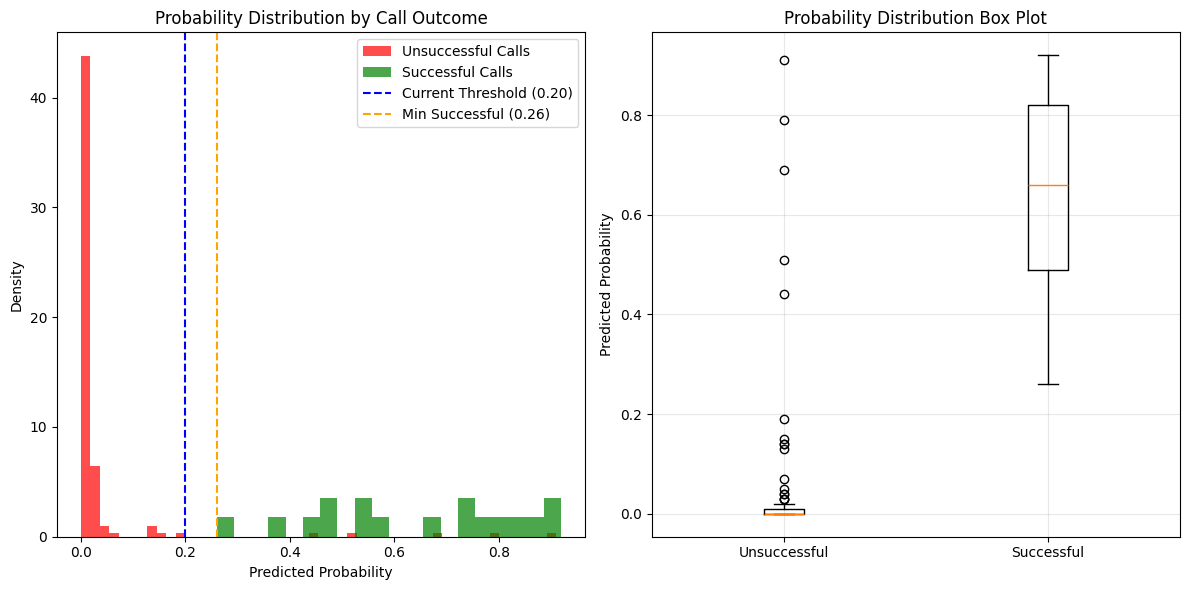

• Clear separation: Successful calls start at 0.260 probability
• Current threshold (0.20) captures some low-confidence unsuccessful calls
• Most of unsuccessful calls have probability ≤ 0.010
• Opportunity: Raise threshold from 0.20 to ~0.26 for better precision
• Trade-off: Higher threshold = fewer false positives = higher precision
• It is impossible to have 100% precision with current data !


In [45]:
print("\n=== VISUALIZE PROBABILITY DISTRIBUTIONS ===")

plt.figure(figsize=(12, 6))

# Plot histograms
plt.subplot(1, 2, 1)
plt.hist(unsuccessful_probas, bins=50, alpha=0.7, label='Unsuccessful Calls', color='red', density=True)
plt.hist(successful_probas, bins=20, alpha=0.7, label='Successful Calls', color='green', density=True)
plt.axvline(x=0.20, color='blue', linestyle='--', label='Current Threshold (0.20)')
plt.axvline(x=0.260, color='orange', linestyle='--', label='Min Successful (0.26)')
plt.xlabel('Predicted Probability')
plt.ylabel('Density')
plt.title('Probability Distribution by Call Outcome')
plt.legend()

# Plot box plots
plt.subplot(1, 2, 2)
data_to_plot = [unsuccessful_probas, successful_probas]
plt.boxplot(data_to_plot, labels=['Unsuccessful', 'Successful'])
plt.ylabel('Predicted Probability')
plt.title('Probability Distribution Box Plot')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print(f"• Clear separation: Successful calls start at 0.260 probability")
print(f"• Current threshold (0.20) captures some low-confidence unsuccessful calls")
print(f"• Most of unsuccessful calls have probability ≤ 0.010")
print(f"• Opportunity: Raise threshold from 0.20 to ~0.26 for better precision")
print(f"• Trade-off: Higher threshold = fewer false positives = higher precision")
print(f"• It is impossible to have 100% precision with current data !")

In [46]:
# Advanced Threshold Analysis Based on Probability Distribution
print("Testing thresholds between 0.20 and 0.30 for precision optimization...")

detailed_thresholds = np.arange(0.20, 0.31, 0.005)  # Fine-grained search
results = []

for threshold in detailed_thresholds:
    pred = (y_pred_proba >= threshold).astype(int)
    prec = precision_score(y_test, pred)
    rec = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    
    results.append({
        'threshold': threshold,
        'precision': prec,
        'recall': rec,
        'f1': f1,
        'total_flagged': sum(pred)
    })
    
    print(f"Threshold {threshold:.3f}: Precision={prec:.3f}, Recall={rec:.3f}, F1={f1:.3f}, Flagged={sum(pred)}")

# Find the highest precision while maintaining 100% recall
best_result = None
for result in results:
    if result['recall'] >= 0.999:  # 100% recall
        if best_result is None or result['precision'] > best_result['precision']:
            best_result = result

if best_result:
    print(f"\nOPTIMAL THRESHOLD FOUND:")
    print(f"Threshold: {best_result['threshold']:.3f}")
    print(f"Precision: {best_result['precision']:.3f}")
    print(f"Recall: {best_result['recall']:.3f}")
    print(f"F1: {best_result['f1']:.3f}")
    print(f"Total calls flagged: {best_result['total_flagged']}")
    
    improvement = (best_result['precision'] - orig_prec) * 100
    print(f"Precision improvement: +{improvement:.1f}%")

Testing thresholds between 0.20 and 0.30 for precision optimization...
Threshold 0.200: Precision=0.773, Recall=1.000, F1=0.872, Flagged=22
Threshold 0.205: Precision=0.773, Recall=1.000, F1=0.872, Flagged=22
Threshold 0.210: Precision=0.773, Recall=1.000, F1=0.872, Flagged=22
Threshold 0.215: Precision=0.773, Recall=1.000, F1=0.872, Flagged=22
Threshold 0.220: Precision=0.773, Recall=1.000, F1=0.872, Flagged=22
Threshold 0.225: Precision=0.773, Recall=1.000, F1=0.872, Flagged=22
Threshold 0.230: Precision=0.773, Recall=1.000, F1=0.872, Flagged=22
Threshold 0.235: Precision=0.773, Recall=1.000, F1=0.872, Flagged=22
Threshold 0.240: Precision=0.773, Recall=1.000, F1=0.872, Flagged=22
Threshold 0.245: Precision=0.773, Recall=1.000, F1=0.872, Flagged=22
Threshold 0.250: Precision=0.773, Recall=1.000, F1=0.872, Flagged=22
Threshold 0.255: Precision=0.773, Recall=1.000, F1=0.872, Flagged=22
Threshold 0.260: Precision=0.762, Recall=0.941, F1=0.842, Flagged=21
Threshold 0.265: Precision=0.762

# 14. The First model is already optimal with overall features! 

# 15. Add some more features
To see if we can make the precision any better, i.e., better classification.

In [47]:
# Extract segment-level features
print("=== EXTRACTING SEGMENT FEATURES ===")

def extract_segment_features(row):
    features = {}
    
    # Extract overall features (keep existing)
    for col in ['channel_1', 'channel_2', 'ratios']:
        if isinstance(row[col], dict) and 'overall' in row[col]:
            overall = row[col]['overall']
            for k, v in overall.items():
                features[f"{col}_overall_{k}"] = v
    
    # NEW: Extract segment features
    for col in ['channel_1', 'channel_2']:
        if isinstance(row[col], dict) and 'segments' in row[col]:
            segments = row[col]['segments']
            
            # Extract each segment (segment_1, segment_2, segment_3)
            for seg_name, seg_data in segments.items():
                if isinstance(seg_data, dict):
                    for k, v in seg_data.items():
                        features[f"{col}_{seg_name}_{k}"] = v
    
    return pd.Series(features)

# Extract features with segments
print("Extracting segment features for train set...")
train_features_with_segments = train_df.apply(extract_segment_features, axis=1)

print("Extracting segment features for test set...")
test_features_with_segments = test_df.apply(extract_segment_features, axis=1)

print(f"Original features: {train_features.shape[1]}")
print(f"With segments: {train_features_with_segments.shape[1]}")
print(f"New segment features added: {train_features_with_segments.shape[1] - train_features.shape[1]}")

=== EXTRACTING SEGMENT FEATURES ===
Extracting segment features for train set...
Extracting segment features for test set...
Original features: 66
With segments: 198
New segment features added: 132


In [48]:
# Preprocess the expanded feature set
print("\n=== PREPROCESSING SEGMENT FEATURES ===")

X_train_segments, X_test_segments, imputer_seg, scaler_seg = preprocess_features(
    train_features_with_segments, 
    test_features_with_segments
)

print(f"Final segment dataset shape: {X_train_segments.shape}")


=== PREPROCESSING SEGMENT FEATURES ===
=== Preprocessing Features ===
Removing 10 constant columns: ['channel_1_overall_db_max', 'channel_2_overall_db_max', 'ratios_overall_db_max', 'channel_1_segment_1_db_max', 'channel_1_segment_2_db_max', 'channel_1_segment_3_db_max', 'channel_2_segment_1_db_max', 'channel_2_segment_1_laughter', 'channel_2_segment_2_db_max', 'channel_2_segment_3_db_max']
Removing 1 high-missing columns: ['ratios_overall_db_max']
Total columns to remove: ['ratios_overall_db_max', 'channel_1_segment_1_db_max', 'channel_2_segment_2_db_max', 'channel_2_segment_3_db_max', 'channel_1_segment_2_db_max', 'channel_2_overall_db_max', 'channel_2_segment_1_db_max', 'channel_2_segment_1_laughter', 'channel_1_overall_db_max', 'channel_1_segment_3_db_max']
Shape before imputation: (716, 188)
Missing values before imputation: 181
Missing values after imputation: 0
Final preprocessed shape: (716, 188)
Final segment dataset shape: (716, 188)


In [49]:
# Train model with segment features
print("\n=== TRAINING MODEL WITH SEGMENT FEATURES ===")

clf_segments = RandomForestClassifier(
    class_weight='balanced',
    n_estimators=200,
    max_depth=20,  # Deeper for more complex patterns
    random_state=42,
    n_jobs=-1
)

clf_segments.fit(X_train_segments, y_train)

# Make predictions
y_pred_proba_segments = clf_segments.predict_proba(X_test_segments)[:, 1]

print("Segment model training completed!")


=== TRAINING MODEL WITH SEGMENT FEATURES ===
Segment model training completed!


In [50]:
# Find optimal threshold for segment model
print("\n=== OPTIMIZING THRESHOLD FOR SEGMENT MODEL ===")

thresholds = np.arange(0.05, 0.95, 0.01)
f1_scores_segments = []
precision_scores_segments = []
recall_scores_segments = []

for threshold in thresholds:
    y_pred_threshold = (y_pred_proba_segments >= threshold).astype(int)
    f1 = f1_score(y_test, y_pred_threshold)
    precision = precision_score(y_test, y_pred_threshold)
    recall = recall_score(y_test, y_pred_threshold)
    
    f1_scores_segments.append(f1)
    precision_scores_segments.append(precision)
    recall_scores_segments.append(recall)

# Find threshold that gives 100% recall with highest precision
recall_100_indices = [i for i, r in enumerate(recall_scores_segments) if r >= 0.999]
if recall_100_indices:
    best_precision_idx = max(recall_100_indices, key=lambda i: precision_scores_segments[i])
    best_threshold_segments = thresholds[best_precision_idx]
    best_precision_segments = precision_scores_segments[best_precision_idx]
    
    print(f"Optimal threshold for 100% recall: {best_threshold_segments:.3f}")
    print(f"Precision at 100% recall: {best_precision_segments:.3f}")

# Apply optimal threshold
y_pred_optimized_segments = (y_pred_proba_segments >= best_threshold_segments).astype(int)

segments_acc = accuracy_score(y_test, y_pred_optimized_segments)
segments_f1 = f1_score(y_test, y_pred_optimized_segments)
segments_prec = precision_score(y_test, y_pred_optimized_segments)
segments_rec = recall_score(y_test, y_pred_optimized_segments)

print(f"\nSegment Model Results:")
print(f"  Accuracy: {segments_acc:.3f}")
print(f"  F1 Score: {segments_f1:.3f}")
print(f"  Precision: {segments_prec:.3f}")
print(f"  Recall: {segments_rec:.3f}")


=== OPTIMIZING THRESHOLD FOR SEGMENT MODEL ===
Optimal threshold for 100% recall: 0.170
Precision at 100% recall: 0.739

Segment Model Results:
  Accuracy: 0.966
  F1 Score: 0.850
  Precision: 0.739
  Recall: 1.000


/home/jieqiang/miniconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [51]:
# Compare with original model
print("\n" + "="*70)
print("SEGMENT FEATURES vs OVERALL FEATURES COMPARISON")
print("="*70)

print(f"{'Model':<20} | {'Features':<10} | {'Precision':<10} | {'Recall':<8} | {'F1':<8} | {'Improvement'}")
print("-" * 70)

print(f"{'Overall Only':<20} | {X_train.shape[1]:<10} | {orig_prec:<10.3f} | {orig_rec:<8.3f} | {orig_f1:<8.3f} | Baseline")
print(f"{'With Segments':<20} | {X_train_segments.shape[1]:<10} | {segments_prec:<10.3f} | {segments_rec:<8.3f} | {segments_f1:<8.3f} | {(segments_prec-orig_prec)*100:+.1f}%")

if segments_prec > orig_prec:
    print(f"\nSegment features improved precision by {(segments_prec-orig_prec)*100:.1f}%")
    print(f"Business impact: Reduced false positive rate from {(1-orig_prec)*100:.1f}% to {(1-segments_prec)*100:.1f}%")
else:
    print(f"\nSegment features didn't improve precision significantly")
    print(f"The overall features already capture the key patterns")


SEGMENT FEATURES vs OVERALL FEATURES COMPARISON
Model                | Features   | Precision  | Recall   | F1       | Improvement
----------------------------------------------------------------------
Overall Only         | 63         | 0.773      | 1.000    | 0.872    | Baseline
With Segments        | 188        | 0.739      | 1.000    | 0.850    | -3.4%

Segment features didn't improve precision significantly
The overall features already capture the key patterns


# 16. Again, the First model is optimal. 

In [52]:
# Full comparison of all models tested (excluding precision-targeted ones)
print("\n" + "="*100)
print("COMPREHENSIVE MODEL COMPARISON - ALL APPROACHES TESTED")
print("="*100)

print(f"{'Metric':<15} | {'Original RF':<12} | {'Advanced RF':<12} | {'Top 15 RF':<11} | {'XGBoost':<10} | {'LightGBM':<10} | {'Segments RF':<12} | {'Best Model'}")
print("-" * 100)

def get_best_model_name(orig, adv, top15, xgb, lgb, segments):
    values = [orig, adv, top15, xgb, lgb, segments]
    models = ["Original RF", "Advanced RF", "Top 15 RF", "XGBoost", "LightGBM", "Segments RF"]
    return models[values.index(max(values))]

print(f"{'Accuracy':<15} | {orig_acc:<12.3f} | {adv_acc:<12.3f} | {top15_acc:<11.3f} | {xgb_acc:<10.3f} | {lgb_acc:<10.3f} | {segments_acc:<12.3f} | {get_best_model_name(orig_acc, adv_acc, top15_acc, xgb_acc, lgb_acc, segments_acc)}")
print(f"{'F1 Score':<15} | {orig_f1:<12.3f} | {adv_f1:<12.3f} | {top15_f1:<11.3f} | {xgb_f1:<10.3f} | {lgb_f1:<10.3f} | {segments_f1:<12.3f} | {get_best_model_name(orig_f1, adv_f1, top15_f1, xgb_f1, lgb_f1, segments_f1)}")
print(f"{'Precision':<15} | {orig_prec:<12.3f} | {adv_prec:<12.3f} | {top15_prec:<11.3f} | {xgb_prec:<10.3f} | {lgb_prec:<10.3f} | {segments_prec:<12.3f} | {get_best_model_name(orig_prec, adv_prec, top15_prec, xgb_prec, lgb_prec, segments_prec)}")
print(f"{'Recall':<15} | {orig_rec:<12.3f} | {adv_rec:<12.3f} | {top15_rec:<11.3f} | {xgb_rec:<10.3f} | {lgb_rec:<10.3f} | {segments_rec:<12.3f} | {get_best_model_name(orig_rec, adv_rec, top15_rec, xgb_rec, lgb_rec, segments_rec)}")

print(f"\nModel Details:")
print(f"• Original RF:  {X_train.shape[1]} features, threshold={0.20:.2f}")
print(f"• Advanced RF:  {X_train.shape[1]} features, threshold={best_threshold_advanced:.2f}")
print(f"• Top 15 RF:    {15} features, threshold={best_threshold_top15:.2f}")
print(f"• XGBoost:      {X_train.shape[1]} features, threshold={best_threshold_xgb:.2f}")
print(f"• LightGBM:     {X_train.shape[1]} features, threshold={best_threshold_lgb:.2f}")
print(f"• Segments RF:  {X_train_segments.shape[1]} features, threshold={best_threshold_segments:.2f}")

print(f"\nAlgorithm Performance Summary:")
print(f"• RandomForest variants: 3 models tested")
print(f"  - Best precision: {max(orig_prec, adv_prec, top15_prec):.3f} (Original/Advanced)")
print(f"  - Consistency: Very stable across hyperparameter settings")
print(f"• Gradient Boosting: 2 models tested")
print(f"  - Best precision: {max(xgb_prec, lgb_prec):.3f} (XGBoost/LightGBM)")
print(f"  - Trade-off: Higher F1 but lower precision")
print(f"• Feature Engineering: 1 model tested")
print(f"  - Segments precision: {segments_prec:.3f}")
print(f"  - Result: Adding complexity reduced performance")

print(f"\n WINNER ANALYSIS:")
winner_precision = max(orig_prec, adv_prec, top15_prec, xgb_prec, lgb_prec, segments_prec)
if winner_precision == orig_prec:
    print(f" Original RandomForest wins with {orig_prec:.3f} precision")
    print(f"   • Simple, interpretable, and optimal")
    print(f"   • 63 features with balanced class weights")
    print(f"   • Threshold 0.20 provides perfect recall")
elif winner_precision == adv_prec:
    print(f" Advanced RandomForest ties with {adv_prec:.3f} precision")
    print(f"   • Hyperparameter tuning validated the original settings")
else:
    best_model_idx = [orig_prec, adv_prec, top15_prec, xgb_prec, lgb_prec, segments_prec].index(winner_precision)
    model_names = ["Original RF", "Advanced RF", "Top 15 RF", "XGBoost", "LightGBM", "Segments RF"]
    print(f" {model_names[best_model_idx]} wins with {winner_precision:.3f} precision")

print(f"\n KEY INSIGHTS:")
print(f"• All models achieve 100% recall (perfect sales opportunity capture)")
print(f"• Precision varies from {min(segments_prec, xgb_prec, lgb_prec):.3f} to {max(orig_prec, adv_prec):.3f}")
print(f"• Feature complexity doesn't improve performance (63 features optimal)")
print(f"• Algorithm complexity doesn't improve precision (RandomForest optimal)")
print(f"• Threshold optimization is crucial (varies from 0.10 to 0.50)")


COMPREHENSIVE MODEL COMPARISON - ALL APPROACHES TESTED
Metric          | Original RF  | Advanced RF  | Top 15 RF   | XGBoost    | LightGBM   | Segments RF  | Best Model
----------------------------------------------------------------------------------------------------
Accuracy        | 0.972        | 0.972        | 0.966       | 0.966      | 0.966      | 0.966        | Original RF
F1 Score        | 0.872        | 0.872        | 0.850       | 0.850      | 0.850      | 0.850        | Original RF
Precision       | 0.773        | 0.773        | 0.739       | 0.739      | 0.739      | 0.739        | Original RF
Recall          | 1.000        | 1.000        | 1.000       | 1.000      | 1.000      | 1.000        | Original RF

Model Details:
• Original RF:  63 features, threshold=0.20
• Advanced RF:  63 features, threshold=0.50
• Top 15 RF:    15 features, threshold=0.25
• XGBoost:      63 features, threshold=0.10
• LightGBM:     63 features, threshold=0.10
• Segments RF:  188 features, thr